<a href="https://colab.research.google.com/github/KENTAROSZK/bert-whitening/blob/main/bert_whitening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install transformers
%pip install fugashi
%pip install ipadic
%pip install unidic-lite
%pip install japanize-matplotlib

In [2]:
# 日本語が使えるようにしておく
import japanize_matplotlib
japanize_matplotlib.japanize()

In [3]:
SOURCE_DIR = "./data/"

## データの準備（DLと解凍、DataFrameへの格納）

In [4]:
# データのDLと解凍

# livedoorデータをDLしてなければ、DLする
import os
if not os.path.exists(SOURCE_DIR + "ldcc-20140209.tar.gz"):
    import subprocess, shlex
    args = shlex.split('wget -P data/ "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"')
    ret = subprocess.run(args, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    print(ret.returncode) # 終了コード。'0'であれば正常終了

# 解凍済みのフォルダが無ければ解凍する
if not os.path.exists(SOURCE_DIR + "livedoor"):
    import tarfile
    tar = tarfile.open(SOURCE_DIR + "ldcc-20140209.tar.gz", 'r:gz')
    tar.extractall(SOURCE_DIR + "livedoor")
    print("extract done")

In [5]:
# 結構時間かかるので、ファイルの有無を確認して、
# 無い場合のみデータの読み込み処理をさせる形にする

import re
import pickle
import pandas as pd


# カテゴリーのフォルダ名のみを抽出
categories = [name for name in os.listdir(
    SOURCE_DIR + "livedoor/text/") if os.path.isdir(SOURCE_DIR + "livedoor/text/"+name)]
print(f"{len(categories)=}\n", f"{categories=}")


is_list_exist = os.path.exists(SOURCE_DIR + "list_df.pkl")

if not is_list_exist:
    list_df = []

    for category in categories:
        path = SOURCE_DIR + "livedoor/text/" + category + "/"
        files = os.listdir(path)
        files_file = [f for f in files if os.path.isfile(os.path.join(path, f)) and (re.match(category, f))]
        for file_name in files_file:
            file = path + file_name
            with open(file) as text_file:
                text = text_file.readlines()
                list_df.append([category, text[2], text[3]])
            #text[2] : # タイトル
            #text[3] : # 本文

    with open(SOURCE_DIR + 'list_df.pkl', mode='wb') as f:
        pickle.dump(list_df, f)
else:
    with open(SOURCE_DIR + 'list_df.pkl', mode='rb') as f:
        list_df = pickle.load(f)

df = pd.DataFrame(list_df, columns = ["category", "title", "content"])
df.head()

len(categories)=9
 categories=['smax', 'sports-watch', 'livedoor-homme', 'it-life-hack', 'topic-news', 'peachy', 'movie-enter', 'dokujo-tsushin', 'kaden-channel']


,category,title,content
0,smax,Microsoft、Windows Phone 7.x搭載端末向けの最新「Windows P...,Windows Phone 7.8が発表！ \n
1,smax,iPhoneユーザー歓喜！？コンビニ無線LAN「LAWSON Wi-Fi」がiPhoneに対応\n,iPhoneユーザーもローソンで無料Wi-Fiが利用可能に \n
2,smax,NTTドコモ、Androidスマートフォン「P-01D」にまれに起動できない不具合があるとし...,P-01Dにソフトウェア更新！ \n
3,smax,夏だ！海だ！プールだ！この夏の泳ぎ計画を立てよう！「全国海水浴場・プールスポット情報検索 泳...,\n
4,smax,NTTドコモ、GALAXY SII SC-02CにAndroid 4.0 ICSへOSバージ...,GALAXY SII SC-02CにAndroid 4.0 ICSが提供開始！ \n


In [6]:
# 各カテゴリでどのくらいの記事数があるかを軽く確認。
df.groupby("category").count()["title"].reset_index()

,category,title
0,dokujo-tsushin,870
1,it-life-hack,870
2,kaden-channel,864
3,livedoor-homme,511
4,movie-enter,870
5,peachy,842
6,smax,870
7,sports-watch,900
8,topic-news,770


## ジャンルが異なる（ベクトルの埋め込み先がまったく異なる方向であって欲しい）テキストを選ぶ

私の主観で、異なるであろう3カテゴリと、その中から内容の方向性が異なる3記事（3×3）を選択した。

- dokujo-tsushin
    - title:地方女子と東京女子の幸せの価値観\n
    - title:今度生まれ変わるなら女or男どちらになりたい？\n
    - title:親が倒れた時、独女は何ができるのか？\n
- it-life-hack
    - title:iPhoneやiPadが目ざまし時計になるユニークなガジェット登場！\n
    - title:高画質と小型・軽量化を両立！キヤノンのミラーレス一眼「EOS M」を見てきました\n
    - title:最近使ったファイルを素早くスタートメニューから開く【知っ得・虎の巻】\n
- sports-watch
    - title:阿部も頭を抱える原采配、ノムさんは「何にもするな、選手に任せておけ」\n
    - title:巨人の拙劣な采配に批判殺到、ノムさんも「根拠がサッパリわからない」\n
    - title:なでしこリーグに警鐘「リーグの意味がない」\n

In [7]:
df[df["category"] == "dokujo-tsushin"].head(30)

,category,title,content
5633,dokujo-tsushin,地方女子と東京女子の幸せの価値観\n,大学を卒業後、上京して就職した佳乃さん(仮名・34歳)が、転職をしたのは、つい最近のこと。転...
5634,dokujo-tsushin,アラフォー独男のイタすぎる自慢話\n,いいかげん耳タコな台詞だが「いいなぁ〜と思う人には、彼女（奥さん）がいる！」と、銀座でも新宿...
5635,dokujo-tsushin,初恋がその後の恋愛を左右する！？\n,誰にでも好きな異性のタイプはある。娘は父に似た人を好きになったり、毛嫌いするケースが多いとい...
5636,dokujo-tsushin,恋愛マニュアル本って本当に使える？\n,片思いの相手を何とかしたい、彼の気持ちがわからない、復縁したい……。そんなときについ手が伸び...
5637,dokujo-tsushin,今度生まれ変わるなら女or男どちらになりたい？\n,草食系男子、号泣男子、スカート男子、乙男（オトメン）、女装子（ジョソコ）など、化粧をしたり、...
5638,dokujo-tsushin,【オトナ女子映画部】愛を捨て快感だけを求める男の孤独とは『SHAME-シェイム-』\n,セックス依存症の男の性生活を赤裸々に描いた映画『SHAME-シェイム-』。本年度受賞レースを...
5639,dokujo-tsushin,【終了しました】健やかで美しい髪を手に入れる「アヴェダ インヴァティセット」を2名様にプレゼ...,3月に入り、少しずつ春の訪れを感じる季節になってきたものの、まだまだ風は冷たく、空気の乾燥に...
5640,dokujo-tsushin,独女的映画レビュー vol.13 『幸せの始まりは』\n,落ち込んだ時に隣にいて欲しいのは、\n
5641,dokujo-tsushin,女性が気になる ”女の香り“の正体を探る\n,五感の中で記憶と結びつきやすい感覚は嗅覚だといわれている。とくに“他人からの香り”というのは...
5642,dokujo-tsushin,「オス化診断」でホルモンバランスをセルフチェック！\n,バブル経済期、流行語大賞・銅賞にも輝くほど増殖した、「オヤジギャル」なんてのがいた。\n


In [8]:
df[df["category"] == "it-life-hack"].head(30)

,category,title,content
2281,it-life-hack,大人のユーモア、大人の対応ですね！孫社長が自分の髪の毛にコメント\n,ソフトバンクグループの代表 孫正義氏は、Twitterを通じて活発な発言をしている。そんな同...
2282,it-life-hack,iPhoneやiPadが目ざまし時計になるユニークなガジェット登場！\n,アスクは、iPhoneやiPadを装着して目ざまし時計代わりにできる「オーディオアラームドッ...
2283,it-life-hack,最近使ったファイルを素早くスタートメニューから開く【知っ得・虎の巻】\n,Windows 7では、スタートメニューに［最近使った項目］がなくなっている。いつも使ってい...
2284,it-life-hack,一粒で三度おいしい虚構新聞！ 一連の騒動に関する検証を掲載\n,先日お知らせした「虚構新聞が更新を一時停止！してますん！という嘘ニュース」「ネタにマジレス何...
2285,it-life-hack,有線スピーカーがBluetooth対応に！ロジクール ワイヤレススピーカーアダプターを限定発売\n,ロジクールからBluetooth機能を搭載していないスピーカーをBluetooth接続のワイ...
2286,it-life-hack,周辺地域の情報をゲット「ご当地ニュースbyロケタッチ新聞」リリース\n,NHN Japan株式会社は、位置情報サービス「ロケタッチ」の関連アプリ「ご当地ニュースby...
2287,it-life-hack,最強の情報リーダーアプリ登場！これでIT系ニュースの網羅は完璧\n,NHN Japan株式会社（以下、NHN Japan）は、同社が提供する「livedoorニ...
2288,it-life-hack,使い方で選べるスマホをラインナップ！ドコモ 2012年夏モデル20機種を発表\n,ドコモは、2012夏モデルのラインアップとして、スマートフオン16機種、タブレット、およびキ...
2289,it-life-hack,かっこ良すぎるまな板！ アスクよりAerocoolの「Strike-X AIR」登場\n,冒頭の写真を見てこれが何だか理解できる人は、かなりのハードウェア通だ。たいていの人は、何だこ...
2290,it-life-hack,本日のGoogleロゴは棒高跳 Googleロゴがスポーツ関連画像に変化第六弾\n,昨日、8月3日に紹介したGoogle検索のトップページのロゴは砲丸投（ショットプット）だった...


In [9]:
df[df["category"] == "sports-watch"].head(30)

,category,title,content
870,sports-watch,ノムさん、佑ちゃんにズバリ 「人気先行だもんな」「いるの、彼女？」\n,TBS「S1」（18日放送分）では、野球解説者・野村克也氏が、北海道日本ハムファイターズのキ...
871,sports-watch,人的補償求めない西武に失望の声が殺到\n,埼玉西武ライオンズは10日、FAでソフトバンクに移籍した帆足和幸投手の補償について、人的補償...
872,sports-watch,【Sports Watch】元巨人・桑田氏が、試合中ボールに向かって呟いていた事とは？\n,野球において、絶対的な得点のチャンスといえるのが、「ノーアウト満塁」というシチュエーションだ...
873,sports-watch,【Sports Watch】なでしこジャパン勝利、決勝＝アメリカ戦の攻略ポイントは…\n,日本時間14日、FIFA女子W杯2011・準決勝の舞台でスウェーデン代表に3-1で大勝した日...
874,sports-watch,小椋久美子、オグシオ・ペア解消について語る\n,11日、TBS「ホンネ日和」では、2010年に26歳でバドミントンを引退した小椋久美子さん（...
875,sports-watch,巨人の拙劣な采配に批判殺到、ノムさんも「根拠がサッパリわからない」\n,15日、ハードオフ新潟で行われたプロ野球＝巨人×DeNAの一戦は、11回裏、中村紀洋のサヨナ...
876,sports-watch,【Sports Watch】取材お断りの天才美少女スイマー\n,大阪で行われた競泳のジャパンオープン（22日）で彗星のように現れた中学3年生の渡部香生子（1...
877,sports-watch,澤穂希、代表ユニフォームに強い想い 「最初に着替えるのは短パンから」\n,London Olympic Watch\n
878,sports-watch,【Sports Watch】ノムさん、落合監督退任発表に「何でこんな時期に・・・」\n,2004年から中日ドラゴンズの指揮を執り、これまでの7シーズンで、1位が3回、2位が3回とい...
879,sports-watch,【Sports Watch】紳助さんの品行にダルビッシュが激怒した事件とは？\n,先月23日、タレント・島田紳助さんが暴力団との付き合いを明らかにし、芸能界引退を発表した。\n


In [10]:
# 選んだ記事のみを抽出して新しいDataFrameを作成する

# - dokujo-tsushin
#     - title:地方女子と東京女子の幸せの価値観\n
#     - title:今度生まれ変わるなら女or男どちらになりたい？\n
#     - title:親が倒れた時、独女は何ができるのか？\n
# - it-life-hack
#     - title:iPhoneやiPadが目ざまし時計になるユニークなガジェット登場！\n
#     - title:高画質と小型・軽量化を両立！キヤノンのミラーレス一眼「EOS M」を見てきました\n
#     - title:最近使ったファイルを素早くスタートメニューから開く【知っ得・虎の巻】\n
# - sports-watch
#     - title:阿部も頭を抱える原采配、ノムさんは「何にもするな、選手に任せておけ」\n
#     - title:巨人の拙劣な采配に批判殺到、ノムさんも「根拠がサッパリわからない」\n
#     - title:なでしこリーグに警鐘「リーグの意味がない」\n


titles = [
    "地方女子と東京女子の幸せの価値観\n",
    "今度生まれ変わるなら女or男どちらになりたい？\n",
    "親が倒れた時、独女は何ができるのか？\n",
    "iPhoneやiPadが目ざまし時計になるユニークなガジェット登場！\n",
    "高画質と小型・軽量化を両立！キヤノンのミラーレス一眼「EOS M」を見てきました\n",
    "最近使ったファイルを素早くスタートメニューから開く【知っ得・虎の巻】\n",
    "阿部も頭を抱える原采配、ノムさんは「何にもするな、選手に任せておけ」\n",
    "巨人の拙劣な采配に批判殺到、ノムさんも「根拠がサッパリわからない」\n",
    "なでしこリーグに警鐘「リーグの意味がない」\n",
]


df_input = df.loc[df["title"].isin(titles)]

display(df_input)

,category,title,content
875,sports-watch,巨人の拙劣な采配に批判殺到、ノムさんも「根拠がサッパリわからない」\n,15日、ハードオフ新潟で行われたプロ野球＝巨人×DeNAの一戦は、11回裏、中村紀洋のサヨナ...
880,sports-watch,阿部も頭を抱える原采配、ノムさんは「何にもするな、選手に任せておけ」\n,1日、東京ドームで行われたプロ野球公式戦＝巨人−中日の一戦は、巨人が7−5で逃げ切り、同一カ...
885,sports-watch,なでしこリーグに警鐘「リーグの意味がない」\n,澤穂希を筆頭に、川澄奈穂美、大野忍、近賀ゆかり、田中明日菜、海堀あゆみら主要なでしこジャパン...
2282,it-life-hack,iPhoneやiPadが目ざまし時計になるユニークなガジェット登場！\n,アスクは、iPhoneやiPadを装着して目ざまし時計代わりにできる「オーディオアラームドッ...
2283,it-life-hack,最近使ったファイルを素早くスタートメニューから開く【知っ得・虎の巻】\n,Windows 7では、スタートメニューに［最近使った項目］がなくなっている。いつも使ってい...
2294,it-life-hack,高画質と小型・軽量化を両立！キヤノンのミラーレス一眼「EOS M」を見てきました\n,キヤノンは2012年7月23日、キヤノンSタワー3階「キヤノンホール S」において、報道関係...
5633,dokujo-tsushin,地方女子と東京女子の幸せの価値観\n,大学を卒業後、上京して就職した佳乃さん(仮名・34歳)が、転職をしたのは、つい最近のこと。転...
5637,dokujo-tsushin,今度生まれ変わるなら女or男どちらになりたい？\n,草食系男子、号泣男子、スカート男子、乙男（オトメン）、女装子（ジョソコ）など、化粧をしたり、...
5646,dokujo-tsushin,親が倒れた時、独女は何ができるのか？\n,「親ももう60歳すぎているし、いつ何があってもおかしくない年齢。わかっていたけど、結局心のど...


In [11]:
# 各contentの文字数をカウントしておく
# -------------------------------------------------
# BERTモデルでインプットできる最大トークン数は512トークンであるため、
# 各コンテンツの文字数がそれを超えていないかどうかを確認しておく.
# 文字数≠トークン数ではあるが、文字数数えれば、おおよそのトークン数は見積もれるため、
# 文字数をカウントする.
# -------------------------------------------------

df_input["content"].apply(lambda x: len(x))

,content
875,81
880,60
885,67
2282,232
2283,104
2294,141
5633,86
5637,215
5646,91


## BERTでembeddingする

In [12]:
# モデルの読み込み
# -------------------------------------------------
# 今回は東北大の日本語bertを使うこととした
# https://huggingface.co/tohoku-nlp/bert-base-japanese-v3
# これが、日本語のBERTを使うときのデファクトスタンダード的立ち位置のモデルだと思う
# -------------------------------------------------

from transformers import BertJapaneseTokenizer, BertModel
import torch

# トークナイザーとモデルの初期化
model_name = "tohoku-nlp/bert-base-japanese-v3"

tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
def embed(text: str) -> torch:
    tokens = tokenizer(text, return_tensors='pt')

    # ベクトルの取得
    with torch.no_grad():
        outputs = model(**tokens)
        # [CLS]トークンの出力を取得（文全体の表現として使用）
        embedding = outputs.last_hidden_state[:, 0, :]

    return embedding


# テストデータでの実験
text = "日本語のテキストを埋め込みベクトルに変換する。"

# 埋め込みベクトルの表示
embedding = embed(text)
print(embedding.shape)
print(embedding)

torch.Size([1, 768])
tensor([[-5.3307e-01,  3.1861e-01, -6.8248e-01,  9.5944e-02, -3.3479e-01,
          1.0736e+00, -7.9251e-01, -2.1434e-01, -2.2504e-01, -6.3049e-01,
          1.5728e-01, -1.2440e-01, -6.8706e-02, -2.2331e-01,  8.1621e-02,
          5.9559e-01,  5.6205e-01,  3.7138e-01, -6.6897e-01, -1.1391e-01,
          4.1173e-01,  4.9424e-02, -5.9612e-01,  5.0083e-01, -4.3349e-01,
          2.5437e-01, -4.8640e-01,  2.2104e-01,  7.5307e-02, -3.5501e-01,
         -1.7728e-01, -2.3050e-01,  1.0583e-01, -1.1085e+01, -6.5359e-01,
          1.6122e-01,  4.4521e-01,  9.1183e-02, -1.3834e-01,  6.0131e-01,
         -3.9717e-01,  6.3918e-02, -2.0906e-01, -5.9148e-02,  6.2810e-01,
          1.9183e-01, -6.0775e-01, -1.4797e-01, -4.2523e-02,  5.6888e-02,
          7.7806e-02,  4.3937e+00, -3.3134e-01, -5.4770e-01,  3.3916e-01,
         -1.7471e-01, -6.4322e-01,  6.9874e-01,  6.6428e-01,  2.7927e-01,
         -3.8730e-01, -1.6792e-01,  3.7313e-01,  7.7227e-01, -1.3252e-01,
          1.5337e

In [14]:
# 各テキストのベクトルを取得する

index_to_id = dict()# DataFrameのオリジナルのindex(key) -> 処理上のindex(value)
id_to_index = dict()# 処理上のindex(key) -> DataFrameのオリジナルのindex(value)
id_to_title = dict()# 処理上のindex(key) -> 記事タイトル(value)


tmp_list_embedding = []

for i, (index,item) in enumerate(df_input.iterrows()):
    index_to_id[index] = i
    id_to_index[i] = index
    id_to_title[i] = item["title"]
    content = item["content"]
    embedding = embed(content)
    tmp_list_embedding.append(embedding)

print(index_to_id)
print(id_to_index)

stacked_tensors = torch.cat(tmp_list_embedding, dim=0)
print(stacked_tensors.shape)

{875: 0, 880: 1, 885: 2, 2282: 3, 2283: 4, 2294: 5, 5633: 6, 5637: 7, 5646: 8}
{0: 875, 1: 880, 2: 885, 3: 2282, 4: 2283, 5: 2294, 6: 5633, 7: 5637, 8: 5646}
torch.Size([9, 768])


## 埋め込みベクトルの類似性を検証する

### 埋め込みした生のベクトルで

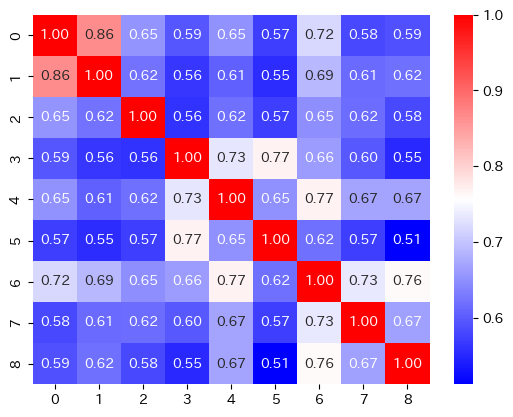

In [15]:
# 類似度行列（cos類似度）を計算する

def cos_sim(tensors: torch):
    import torch.nn.functional as F
    # 各ベクトルを L2 ノルムで正規化
    normalized_tensors = F.normalize(tensors, p=2, dim=1)
    # コサイン類似度行列を計算
    similarity_matrix = torch.matmul(normalized_tensors, normalized_tensors.transpose(0, 1))
    return similarity_matrix


def visualise_cos_sim_mat(sim_mat: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.heatmap(sim_mat, cmap='bwr', annot=True, fmt=".2f")


cs = cos_sim(stacked_tensors)
visualise_cos_sim_mat(sim_mat = pd.DataFrame(cs))

### whitening処理した後で

In [16]:
def whitening(tensors: torch) -> (torch, torch, torch):
    """
    データ行列（今回は、9×768の行列）を新しい直交空間(座標)での表現に変換する。
    """
    # ----------------------------------------------------------
    # step1.分散共分散行列を計算する

    # 各特徴量の平均を計算
    mean = torch.mean(tensors, dim=0)
    # 各ベクトルから平均ベクトルを引き算
    centered_tensors = tensors - mean
    # 分散共分散行列を計算
    covariance_matrix = torch.matmul(centered_tensors.transpose(0, 1), centered_tensors) / (tensors.shape[0] - 1)

    # ----------------------------------------------------------
    # step2.対角化して、（単位ベクトル化済みの）固有ベクトルを並べたテンソル(768×768)を作る

    # 固有値固有ベクトルを計算
    eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)
    # 固有ベクトルを単位ベクトルに変換
    eigenvectors = eigenvectors / torch.norm(eigenvectors, p=2, dim=0, keepdim=True)
    # 固有ベクトルを縦ベクトルと見なしてテンソルを作成
    eigenvector_tensor = eigenvectors.real  # 複素数を実数に変換 (必要な場合)

    # ----------------------------------------------------------
    # step3.
    # 上記で求めた固有ベクトルが張る空間に
    # 中心化済みのオリジナルデータ行列（9×768）を射影する
    # 中心化済みのオリジナルデータ行列をcentered_tensorsとして、新しいデータ行列をXとすると、
    # X = (centered_tensors @ eigenvector_tensor).transpose()

    # テンソル積を計算
    X = torch.matmul(centered_tensors, eigenvector_tensor).transpose(0, 1)
    X_new = X.transpose(0, 1)

    return X_new, mean, eigenvector_tensor

X_new, mean, U = whitening(stacked_tensors)
print(X_new.shape)

torch.Size([9, 768])


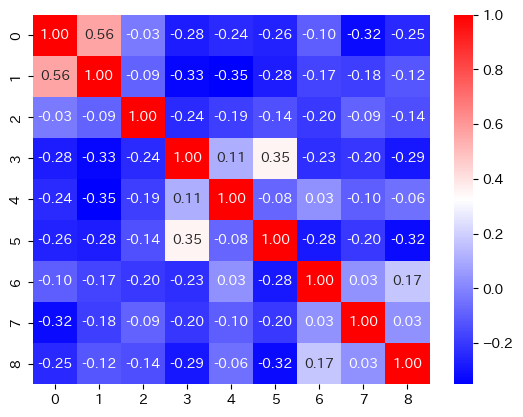

In [17]:
cs = cos_sim(X_new)
visualise_cos_sim_mat(sim_mat = pd.DataFrame(cs))

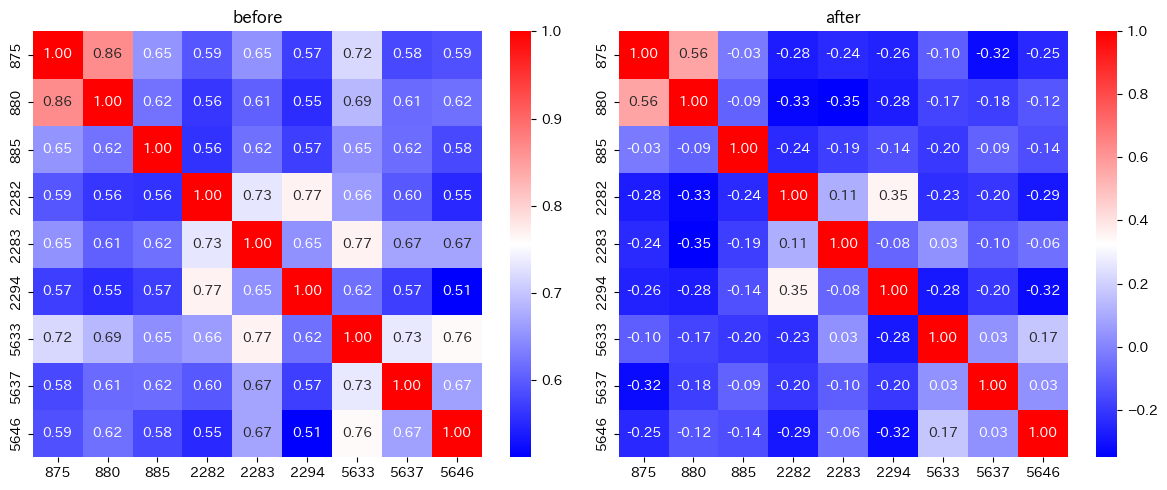

In [18]:
def visualise_heatmap_horizontally(
        sim_mat1: pd.DataFrame,
        sim_mat2: pd.DataFrame
    ) -> None:
    import matplotlib.pyplot as plt
    import seaborn as sns

    # FigureとAxesの作成 (1行2列のsubplots)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # figsizeで全体のサイズを調整


    sns.heatmap(sim_mat1, ax=axes[0], cmap='bwr', annot=True, fmt=".2f")
    axes[0].set_title("before")
    sns.heatmap(sim_mat2, ax=axes[1], cmap='bwr', annot=True, fmt=".2f")
    axes[1].set_title("after")

    # レイアウト調整 (必要であれば)
    plt.tight_layout()
    plt.show()


visualise_heatmap_horizontally(
    sim_mat1 = pd.DataFrame(cos_sim(stacked_tensors), index=list(id_to_index.values()), columns=list(id_to_index.values())),
    sim_mat2 = pd.DataFrame(cos_sim(X_new), index=list(id_to_index.values()), columns=list(id_to_index.values()))
)


['巨人の拙', '阿部も頭', 'なでしこ', 'iPho', '最近使っ', '高画質と', '地方女子', '今度生ま', '親が倒れ']


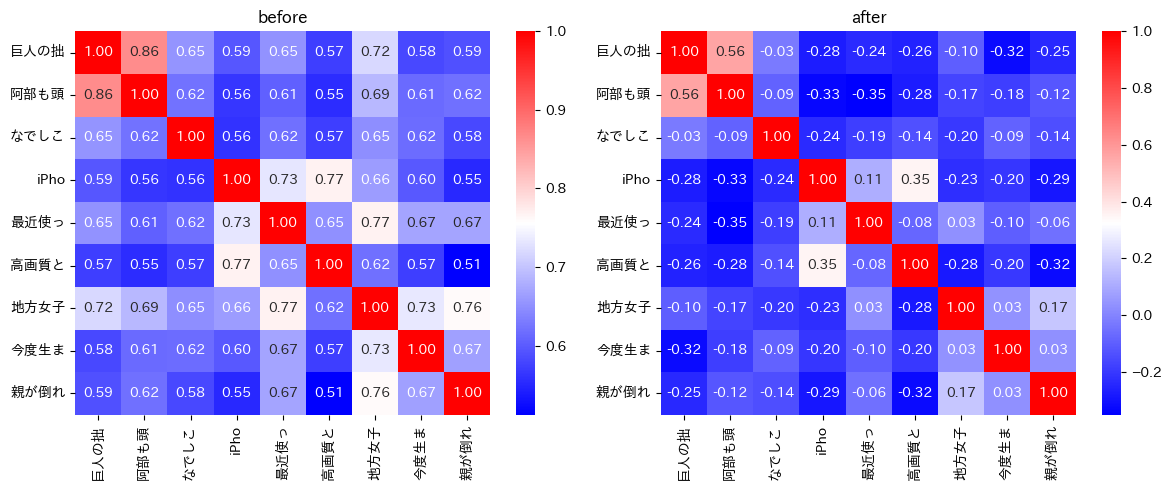

In [19]:
# 記事のindexだとわかりづらいので、
# タイトルで表示できるようにする

# ただ、タイトルをそのまま表示しようとすると長すぎるので、
# タイトルの冒頭4文字くらいだけ表示する

id_to_title_new = [s[:4] for s in id_to_title.values()]
print(id_to_title_new)

visualise_heatmap_horizontally(
    sim_mat1 = pd.DataFrame(cos_sim(stacked_tensors), index=list(id_to_title_new), columns=list(id_to_title_new)),
    sim_mat2 = pd.DataFrame(cos_sim(X_new), index=list(id_to_title_new), columns=list(id_to_title_new))
)

- ①：固有ベクトル空間での表現とすることで、負の値が出るようになった。
- ②：before, afterとで"似ている"と判断する閾値が大きく変わった。私としてはより直感的になった、と思う。
    - before：0.7を超えると"似ている"、それよりも小さい場合は、"似ていない"という解釈の仕方になりそう。
    - after：正の値であれば、ある程度似ている、と言えるような結果になった。


## 追加検証

- 追加検証1：類似記事での出力が"類似"と判断できる変換ができているか？
- 追加検証2：似ていない記事での出力が"似ていない"と判断できる変換ができているか？

,category,title,content
2294,it-life-hack,高画質と小型・軽量化を両立！キヤノンのミラーレス一眼「EOS M」を見てきました\n,キヤノンは2012年7月23日、キヤノンSタワー3階「キヤノンホール S」において、報道関係...
2315,it-life-hack,スティックタイプのコンデジ登場！ Optio新モデルは気分に合わせて着せ替え可能\n,ペンタックスリコーイメージングは、同社のコンパクトデジタルカメラ「Optio」シリーズに新モ...


torch.Size([2, 768])


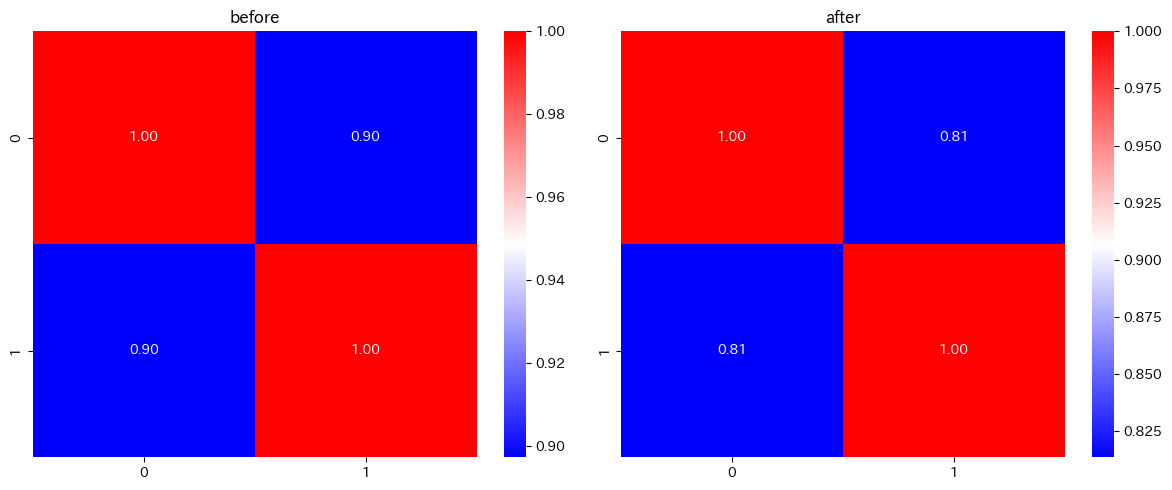

In [20]:
# 追加検証1

# 似ている記事同士で似ていると判断できるか？
titles = [
    "高画質と小型・軽量化を両立！キヤノンのミラーレス一眼「EOS M」を見てきました\n", # オリジナル
    "スティックタイプのコンデジ登場！　Optio新モデルは気分に合わせて着せ替え可能\n", # 類似してる（孫社長がいるという意味で）記事
]


# DataFrameを作成する
df_input1 = df.loc[df["title"].isin(titles)]
display(df_input1)

# embedding
tmp_list_embedding = []
for i, (index,item) in enumerate(df_input1.iterrows()):
    content = item["content"]
    embedding = embed(content)
    tmp_list_embedding.append(embedding)
stacked_tensors1 = torch.cat(tmp_list_embedding, dim=0)

# データ行列（2×768行列）を変換する
# さっき計算して算出していた`mean`と固有ベクトルを並べたテンソル `U` を利用する
tensors1 = stacked_tensors1 - mean
X_new1 = torch.matmul(tensors1, U).transpose(0, 1)
X_new1 = X_new1.transpose(0,1)
print(X_new1.shape)


# 可視化
#cs = cos_sim(X_new1)
#visualise_cos_sim_mat(sim_mat = pd.DataFrame(cs))

visualise_heatmap_horizontally(
    sim_mat1 = pd.DataFrame(cos_sim(stacked_tensors1)),
    sim_mat2 = pd.DataFrame(cos_sim(X_new1))
)

,category,title,content
5633,dokujo-tsushin,地方女子と東京女子の幸せの価値観\n,大学を卒業後、上京して就職した佳乃さん(仮名・34歳)が、転職をしたのは、つい最近のこと。転...
5637,dokujo-tsushin,今度生まれ変わるなら女or男どちらになりたい？\n,草食系男子、号泣男子、スカート男子、乙男（オトメン）、女装子（ジョソコ）など、化粧をしたり、...
5646,dokujo-tsushin,親が倒れた時、独女は何ができるのか？\n,「親ももう60歳すぎているし、いつ何があってもおかしくない年齢。わかっていたけど、結局心のど...
5650,dokujo-tsushin,ダイエット不要！ぽっちゃり系の時代が到来！？\n,先日、携帯電話を買い替えるために家電量販店へ行ったところ、担当の販売員の方が、柳原可奈子にそ...


torch.Size([4, 768])


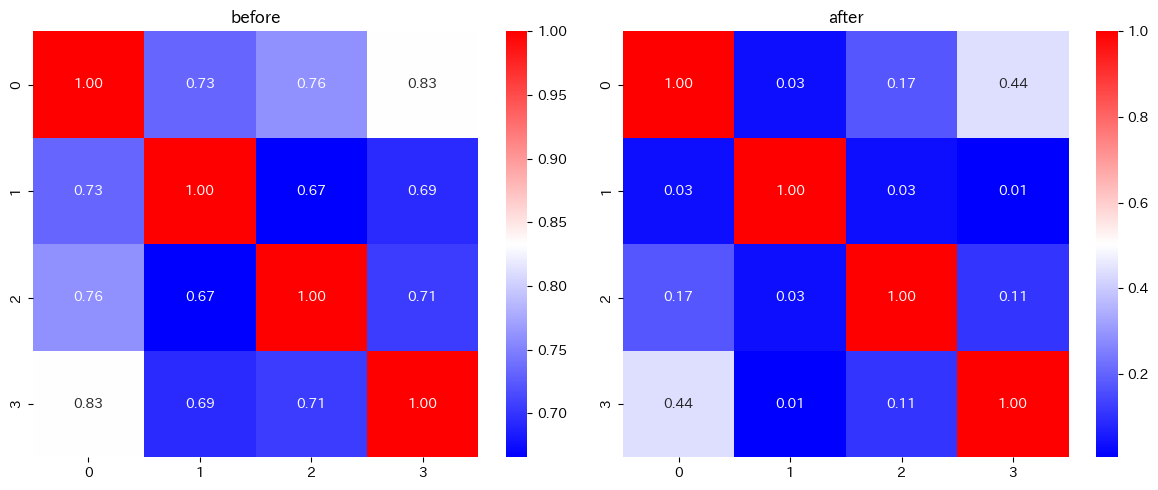

In [21]:
# 追加検証2

# 似ていない記事を似ていないと判断できるか？
titles = [
    "地方女子と東京女子の幸せの価値観\n", # オリジナル記事
    "今度生まれ変わるなら女or男どちらになりたい？\n", # オリジナル記事
    "親が倒れた時、独女は何ができるのか？\n", # オリジナル記事
    "ダイエット不要！ぽっちゃり系の時代が到来！？\n", # dokujo-tsushinカテゴリの中で似ていない記事
]


# DataFrameを作成する
df_input2 = df.loc[df["title"].isin(titles)]
display(df_input2)

# embedding
tmp_list_embedding = []
for i, (index,item) in enumerate(df_input2.iterrows()):
    content = item["content"]
    embedding = embed(content)
    tmp_list_embedding.append(embedding)
stacked_tensors2 = torch.cat(tmp_list_embedding, dim=0)

# データ行列（2×768行列）を変換する
# さっき計算して算出していた`mean`と固有ベクトルを並べたテンソル `U` を利用する
tensors2 = stacked_tensors2 - mean
X_new2 = torch.matmul(tensors2, U).transpose(0, 1)
X_new2 = X_new2.transpose(0,1)
print(X_new2.shape)


# 可視化
visualise_heatmap_horizontally(
    sim_mat1 = pd.DataFrame(cos_sim(stacked_tensors2)),
    sim_mat2 = pd.DataFrame(cos_sim(X_new2))
)